Authors: Andreas Haupt, Jannis Kück, Alexander Quispe and Anzony Quispe, Vasilis Syrgkanis

# Testing the Convergence Hypothesis

In [1]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 3.0 MB/s eta 0:00:00
Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0
Receiving objects: 100% (70/70), 25.30 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
!pip install wget # for data loading

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5b54376f175198eee007482b053eaaf354bbf9a131a1927a3290e49b18088342
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import sys
import math
import random
import wget
import hdmpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [4]:
from pyreadr import read_r

sys.path.insert(1, "./hdmpy")

## Introduction

We provide an additional empirical example of partialling-out with Lasso to estimate the regression coefficient $\beta_1$ in the high-dimensional linear regression model:
  $$
  Y = \beta_1 D +  \beta_2'W + \epsilon.
  $$
  
Specifically, we are interested in how the rates  at which economies of different countries grow ($Y$) are related to the initial wealth levels in each country ($D$) controlling for country's institutional, educational, and other similar characteristics ($W$).
  
The relationship is captured by $\beta_1$, the *speed of convergence/divergence*, which measures the speed at which poor countries catch up $(\beta_1< 0)$ or fall behind $(\beta_1> 0)$ rich countries, after controlling for $W$. Our inference question here is: do poor countries grow faster than rich countries, controlling for educational and other characteristics? In other words, is the speed of convergence negative: $ \beta_1 <0?$ This is the Convergence Hypothesis predicted by the Solow Growth Model. This is a structural economic model. Under some strong assumptions, that we won't state here, the predictive exercise we are doing here can be given causal interpretation.


The outcome $Y$ is the realized annual growth rate of a country's wealth  (Gross Domestic Product per capita). The target regressor ($D$) is the initial level of the country's wealth. The target parameter $\beta_1$ is the speed of convergence, which measures the speed at which poor countries catch up with rich countries. The controls ($W$) include measures of education levels, quality of institutions, trade openness, and political stability in the country.

## Data analysis


We consider the data set GrowthData which is included in the package *hdm*. First, let us load the data set to get familiar with the data.

In [5]:
# I downloaded the data that the author used
fname = "https://github.com/CausalAIBook/MetricsMLNotebooks/blob/main/data/GrowthData.rda?raw=true"
growth_read = read_r(wget.download(fname))

# Extracting the data frame from rdata_read
growth = growth_read['GrowthData']

We determine the dimension of our data set.

The sample contains $90$ countries and $63$ controls.

In [6]:
growth.shape

(90, 63)

Thus $p \approx 60$, $n=90$ and $p/n$ is not small. We expect the least squares method to provide a poor estimate of $\beta_1$.  We expect the method based on partialling-out with Lasso to provide a high quality estimate of $\beta_1$.
To check this hypothesis, we analyze the relation between the output variable $Y$ and the other country's characteristics by running a linear regression in the first step.

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [8]:
y = growth['Outcome']
X = growth.drop('Outcome', axis=1)

In [12]:
reg_ols  = sm.OLS(y, X).fit(cov_type='HC1')

In [13]:
# output: estimated regression coefficient corresponding to the target regressor
est_ols = reg_ols.params['gdpsh465']
# output: HC1 std. error
std_ols = reg_ols.HC1_se['gdpsh465']
# output: 95% confidence interval
lower_ci, upper_ci = reg_ols.conf_int(alpha=0.05).loc['gdpsh465'].values

## Summarize OLS results

In [14]:
table = pd.DataFrame(columns=["Estimator", "Std. Error", "lower bound CI", "upper bound CI"])
table.loc['OLS'] = [est_ols, std_ols, lower_ci, upper_ci]
table

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.032421,-0.140565,0.121809


Least squares provides a rather noisy estimate (high standard error) of the
speed of convergence, and does not allow us to answer the question
about the convergence hypothesis since the confidence interval includes zero.

In contrast, we can use the partialling-out approach based on lasso regression ("Double Lasso").

In [15]:
y = growth['Outcome'].values
W = growth.drop(['Outcome', 'intercept', 'gdpsh465'], axis=1)
D = growth['gdpsh465'].values

## Method 1 - Lasso with Theoretical Setting of Penalty using HDMPY

While cross validation is commonly employed for choosing penalty parameters in Lasso, it can be very noisy and tends to choose relatively small penalty leading to some overfitting. For this reason, one should not use cross validation to choose tuning parameters unless sample splitting is employed. We illustrate the use of sample combined with cross validation in later chapters in the book. Since we are using the full sample here, it is much better (and theoretically valid) to use penalties that provably control overfitting, which is what we do here.

We report the results using cross validation at the end of this notebook for comparison. There, we observe overfitting for the prediction of the outcome.

In [16]:
res_y = hdmpy.rlasso(W, y, post=False).est['residuals']
res_D = hdmpy.rlasso(W, D, post=False).est['residuals']

r_y = pd.DataFrame(res_y, columns=['r_y'])
r_D = pd.DataFrame(res_D, columns=['r_D'])

In [17]:
# OLS regression
reg_ols  = sm.OLS(r_y, r_D).fit(cov_type='HC1')

In [18]:
reg_ols.params['r_D']

-0.04469264943858358

In [19]:
est = reg_ols.params['r_D']
stderr = reg_ols.HC1_se['r_D']
lower_ci, upper_ci = reg_ols.conf_int(alpha=0.05).loc['r_D'].values
table.loc['Double Lasso'] = [est, stderr, lower_ci, upper_ci]
table

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.032421,-0.140565,0.121809
Double Lasso,-0.044693,0.017923,-0.079821,-0.009564


The least square method provides a rather noisy estimate of the speed of convergence. We can not answer the question if poor countries grow faster than rich countries. The least square method does not work when the ratio $p/n$ is large.

In sharp contrast, partialling-out via Lasso provides a more precise estimate. The Lasso based point estimate is $-5\%$ and the $95\%$ confidence interval for the (annual) rate of convergence $[-7.8\%,-2.2\%]$ only includes negative numbers. This empirical evidence does support the convergence hypothesis.

## Method 2: Using Cross-Validated Lasso

This section is for illustration purposes only. Given that we are using the full sample, cross validation *should not* be used for choosing tuning parameters here. Cross validation tends to (mildly) overfit, and this overfitting can lead to substantial problems when inference about parameters is the goal.

In [20]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

# Choose penalty based on KFold cross validation
# Given small sample size, we use an aggressive number of 20 folds
cv = KFold(n_splits=20, shuffle=True, random_state=123)
model_y = make_pipeline(StandardScaler(),
                        linear_model.LassoCV(n_alphas=10, cv=cv, max_iter=10000))

res_y = y - model_y.fit(W, y).predict(W)
r_y = pd.DataFrame(res_y, columns=['r_y'])

model_d = make_pipeline(StandardScaler(),
                        linear_model.LassoCV(n_alphas=10, cv=cv, max_iter=10000))
res_D = D - model_d.fit(W, D).predict(W)
r_D = pd.DataFrame(res_D, columns=['r_D'])

In [21]:
# OLS regression
reg_ols  = sm.OLS(r_y, r_D).fit(cov_type='HC1')

In [22]:
est = reg_ols.params['r_D']
stderr = reg_ols.HC1_se['r_D']
lower_ci, upper_ci = reg_ols.conf_int(alpha=0.05).loc['r_D'].values
table.loc['Double Lasso-CV'] = [est, stderr, lower_ci, upper_ci]
table

,Estimator,Std. Error,lower bound CI,upper bound CI
OLS,-0.009378,0.032421,-0.140565,0.121809
Double Lasso,-0.044693,0.017923,-0.079821,-0.009564
Double Lasso-CV,-0.001705,0.008241,-0.017856,0.014446


We find that the outcome model chooses too small of a penalty based on cross-validation, leading to overfitting of the outcome and tiny outcome residuals. This leads to artificially small standard errors and a zero treatment effect. Theoretically driven penalty should be preferred for such small sample sizes.

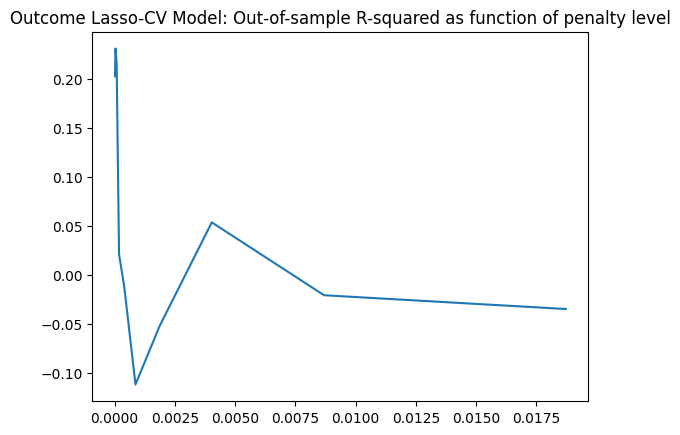

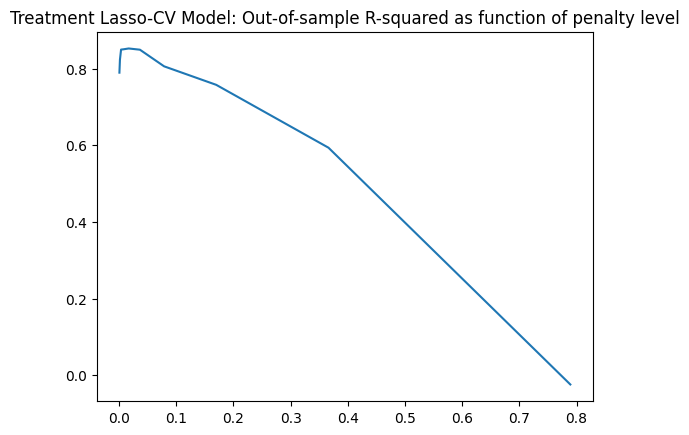

In [23]:
import matplotlib.pyplot as plt

plt.plot(model_y[-1].alphas_, 1 - model_y[-1].mse_path_.mean(axis=1) / np.var(y))
plt.title('Outcome Lasso-CV Model: Out-of-sample R-squared as function of penalty level')
plt.show()
plt.title('Treatment Lasso-CV Model: Out-of-sample R-squared as function of penalty level')
plt.plot(model_d[-1].alphas_, 1 - model_d[-1].mse_path_.mean(axis=1) / np.var(D))
plt.show()